#Crop price forcasting


In [1]:
# get data
! wget https://raw.githubusercontent.com/Pataweepr/scb_TS_course/master/exam/time-series/cropprice2013-2017.csv

--2023-10-16 15:54:46--  https://raw.githubusercontent.com/Pataweepr/scb_TS_course/master/exam/time-series/cropprice2013-2017.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4314 (4.2K) [text/plain]
Saving to: ‘cropprice2013-2017.csv’

cropprice2013-2017. 100%[===================>]   4.21K  --.-KB/s    in 0s      

2023-10-16 15:54:47 (51.0 MB/s) - ‘cropprice2013-2017.csv’ saved [4314/4314]



In [2]:
!pip install statsmodels -U # colab uses an old version of statsmodels

In [3]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [4]:
df = pd.read_csv("cropprice2013-2017.csv", header=None)
df.columns = (['datetime','value'])
df

,datetime,value
0,24/2/2013,10.15942
1,3/3/2013,10.25856
2,10/3/2013,10.27626
3,17/3/2013,10.44566
4,24/3/2013,10.60654
...,...,...
225,6/8/2017,6.10300
226,13/8/2017,6.10650
227,20/8/2017,5.98150
228,27/8/2017,5.87450


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

<ipython-input-5-21f38a6317ac>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['datetime'] = pd.to_datetime(df['datetime'])


In [6]:
df = df.sort_values(by='datetime')
df

,value
datetime,
2013-01-09,9.09130
2013-01-12,8.16952
2013-02-06,10.10080
2013-02-24,10.15942
2013-03-03,10.25856
...,...
2017-08-27,5.87450
2017-09-04,6.18920
2017-09-07,6.30340


In [7]:
df_day = df.resample('1D').interpolate(method='linear')
df_day

,value
datetime,
2013-01-09,9.091300
2013-01-10,8.784040
2013-01-11,8.476780
2013-01-12,8.169520
2013-01-13,8.246771
...,...
2017-11-29,6.330867
2017-11-30,6.331198
2017-12-01,6.331529


In [8]:
df_sun = df_day[4:].resample('7D').first()
df_sun

,value
datetime,
2013-01-13,8.246771
2013-01-20,8.787530
2013-01-27,9.328288
2013-02-03,9.869046
2013-02-10,10.113827
...,...
2017-11-05,6.322925
2017-11-12,6.325241
2017-11-19,6.327558


## Multiplicative Time Series

<Axes: xlabel='datetime'>

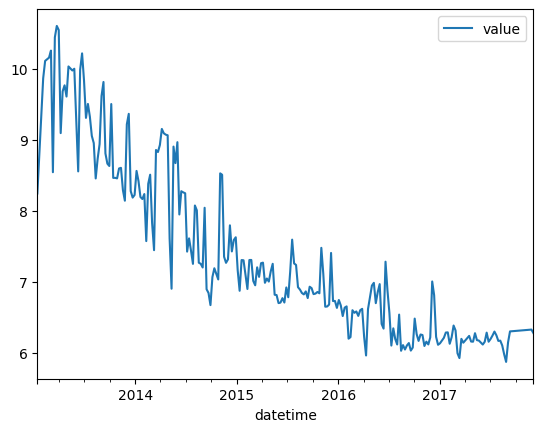

In [9]:
df_sun.plot()

In [10]:
import statsmodels.api as sm

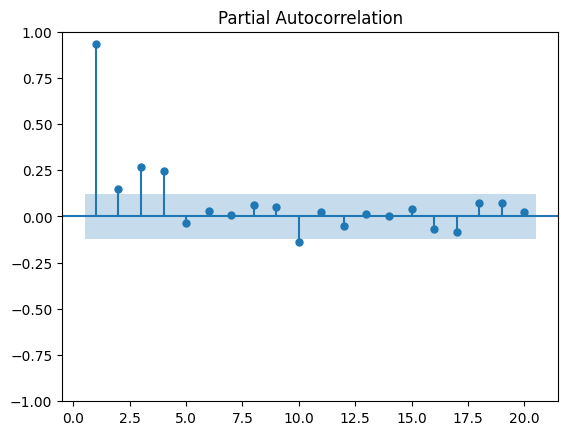

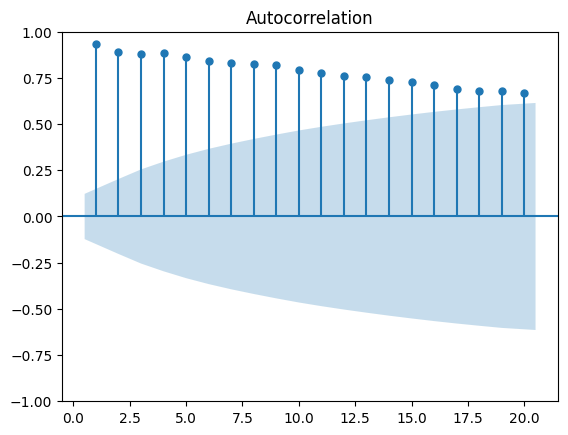

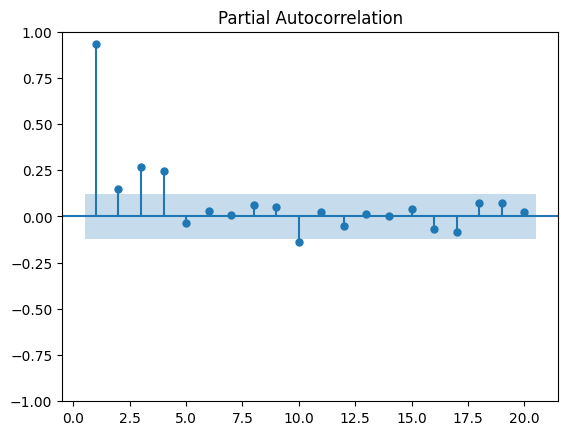

In [11]:
sm.tsa.graphics.plot_acf(df_sun, lags=20, zero=False)
sm.tsa.graphics.plot_pacf(df_sun, lags=20, zero=False)

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [13]:
mul_decom = seasonal_decompose(x=df_sun, model='multiplicative', period=4)
mul_trend = mul_decom.trend
mul_seasonal = mul_decom.seasonal
mul_residual = mul_decom.resid

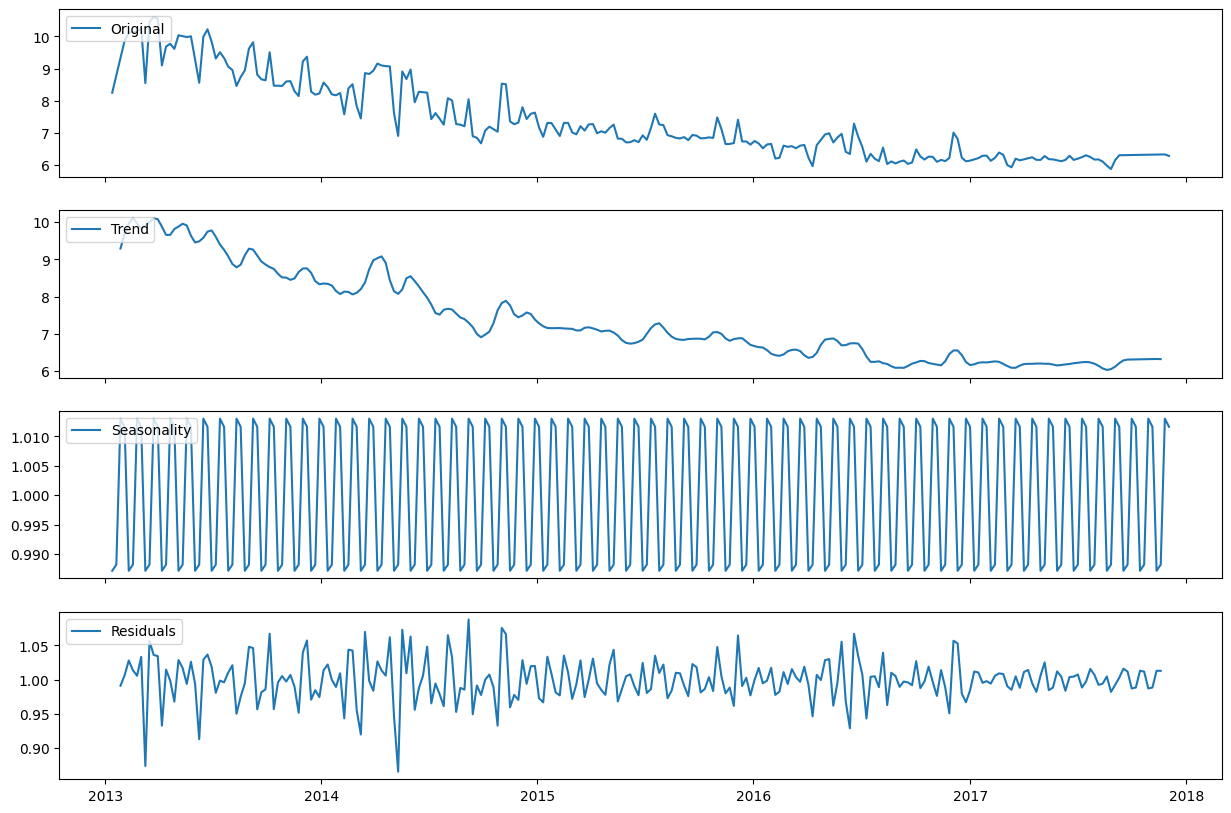

In [14]:
fig, ax = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

ax[0].plot(df_sun, label='Original')
ax[0].legend(loc='upper left');

ax[1].plot(mul_trend, label='Trend')
ax[1].legend(loc='upper left');

ax[2].plot(mul_seasonal, label='Seasonality')
ax[2].legend(loc='upper left');

ax[3].plot(mul_residual, label='Residuals')
ax[3].legend(loc='upper left');

From partial correlation seem like the data has seasonality with period around 4.

### Is this data stationary?

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
def get_ADCF_test(series):
    dftest = adfuller(series)
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [17]:
get_ADCF_test(df_sun)

Test Statistic           -1.702047
p-value                   0.430058
Lags Used                 8.000000
Observations Used       247.000000
Critical Value (1%)      -3.457105
Critical Value (5%)      -2.873314
Critical Value (10%)     -2.573044
dtype: float64


Not stationary from Dickey Fuller Test p-value is greater than 0.05.

In [18]:
df_sun_log = np.log(df_sun)

<Axes: xlabel='datetime'>

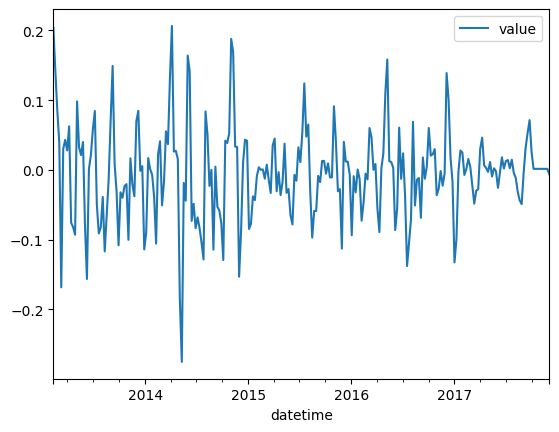

In [19]:
df_diff = df_sun_log.diff(4).dropna()
df_diff.plot()

In [20]:
get_ADCF_test(df_diff)

Test Statistic           -4.803226
p-value                   0.000054
Lags Used                16.000000
Observations Used       235.000000
Critical Value (1%)      -3.458487
Critical Value (5%)      -2.873919
Critical Value (10%)     -2.573367
dtype: float64


### Create a model to predict the price in year 2017.

In [21]:
df_train = df_sun_log.loc['2013':'2016']
print(df_train)

               value
datetime            
2013-01-13  2.109822
2013-01-20  2.173334
2013-01-27  2.233052
2013-02-03  2.289403
2013-02-10  2.313903
...              ...
2016-11-27  1.827818
2016-12-04  1.946971
2016-12-11  1.918928
2016-12-18  1.828978
2016-12-25  1.810918

[207 rows x 1 columns]


In [22]:
df_test = df_sun_log.loc['2017']
df_test

,value
datetime,
2017-01-01,1.814234
2017-01-08,1.820526
2017-01-15,1.826779
2017-01-22,1.838665
2017-01-29,1.839098
2017-02-05,1.813224
2017-02-12,1.828208
2017-02-19,1.854274
2017-02-26,1.843393


In [23]:
import warnings

warnings.filterwarnings("ignore")

##ARMA

In [24]:
from sklearn.metrics import mean_squared_error

# Define the range of AR and MA orders you want to search through
max_p = 5
max_q = 5

# Perform the grid search
best_mse = float('inf')
best_p, best_q = 0, 0

for p in range(1, max_p + 1):
    for q in range(1, max_q + 1):
        try:
            # Fit the ARMA model
            arma_model = sm.tsa.ARIMA(df_train, order=(p, 0, q)).fit()

            # Make predictions on the validation set
            predictions = arma_model.predict(start=len(df_train), end=len(df_sun_log) - 1)

            # Calculate the MSE
            mse = mean_squared_error(df_test, predictions)

            # Check if this is the best model so far
            if mse < best_mse:
                best_mse = mse
                best_p, best_q = p, q
        except:
            continue

# Now, you can retrain the best ARMA model using the entire dataset
best_arma_model = sm.tsa.ARIMA(df_sun_log, order=(best_p, 0, best_q)).fit()

# You can now use 'best_arma_model' for predictions or further analysis


In [25]:
print(f"Best AR Order (p): {best_p}")
print(f"Best MA Order (q): {best_q}")
print(f"Best MSE: {best_mse}")

Best AR Order (p): 2
Best MA Order (q): 3
Best MSE: 0.0008872378600187067


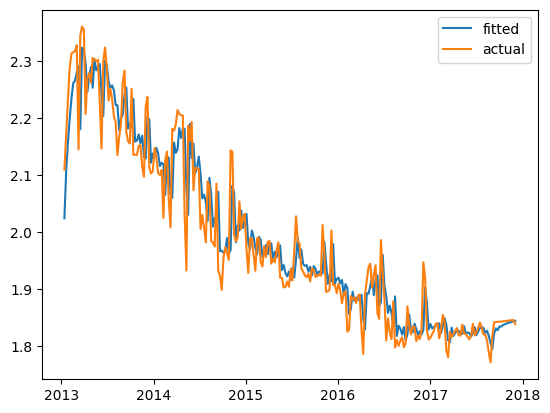

In [26]:
plt.plot(best_arma_model.fittedvalues,label = 'fitted')
plt.plot(df_sun_log,label = 'actual')
plt.legend()
plt.show()

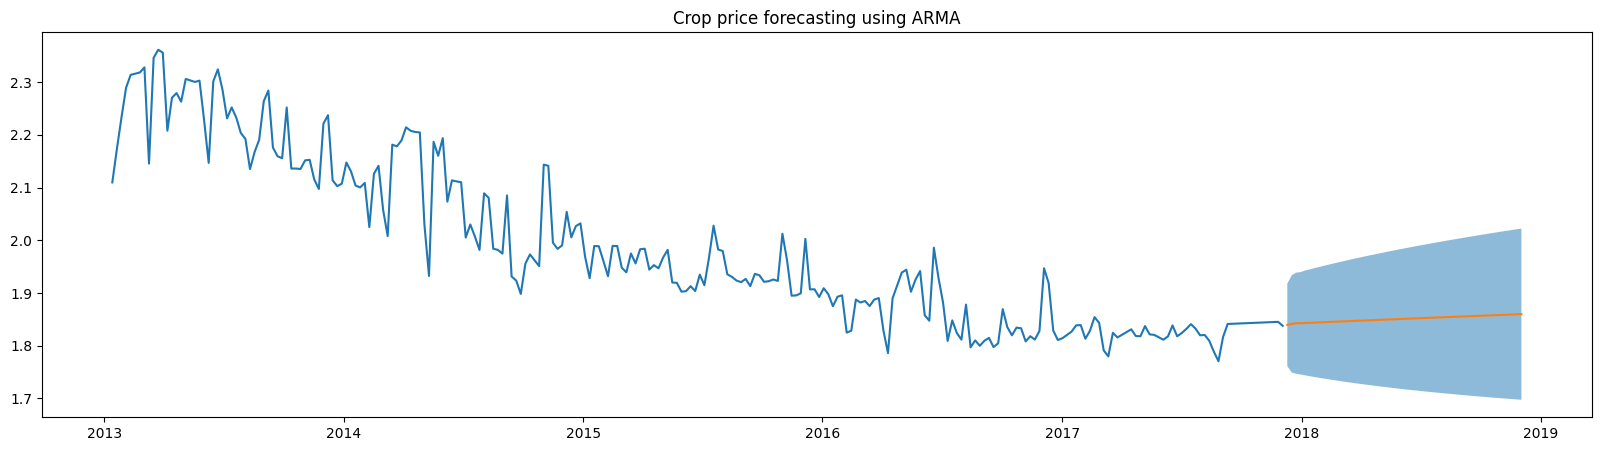

In [27]:
future_fcst = best_arma_model.get_forecast(steps=52)
confidence_int = future_fcst.conf_int(alpha = 0.1)
fcst = future_fcst.predicted_mean

plt.figure(figsize = (20, 5))
plt.title('Crop price forecasting using ARMA')
plt.plot(df_sun_log)
plt.plot(fcst, label = 'forcast')
plt.fill_between(confidence_int.index,confidence_int['lower value'],confidence_int['upper value'],alpha = 0.5)
plt.show()

##ARIMA

In [28]:
df_train = df_sun.loc['2013':'2016']
df_test = df_sun.loc['2017']

In [29]:
from itertools import product

In [30]:
p_values = range(0, 6)  # AR order
d_values = range(0, 3)  # Differencing order
q_values = range(0, 6)  # MA order

best_score, best_params = float('inf'), None

# Perform ARIMA grid search
for p, d, q in product(p_values, d_values, q_values):
    try:
        # Fit ARIMA model
        arima_model = sm.tsa.ARIMA(df_train, order=(p, d, q))
        model_fit = arima_model.fit()

        # Make predictions on validation set
        y_pred = model_fit.forecast(steps=len(df_test))

        # Calculate Mean Squared Error as the evaluation metric
        mse = mean_squared_error(df_test, y_pred)

        # Update the best model if current MSE is lower
        if mse < best_score:
            best_score, best_params = mse, (p, d, q)

    except:
        # If the ARIMA model fails to converge, continue to the next combination
        continue

# Fit the best ARIMA model on the entire dataset
best_model = sm.tsa.ARIMA(df_sun, order=best_params)
best_arima_model = best_model.fit()

In [31]:
print("Best ARIMA Model Parameters:", best_params)
print("Best MSE:", best_score)

Best ARIMA Model Parameters: (2, 1, 0)
Best MSE: 0.015935300433656846


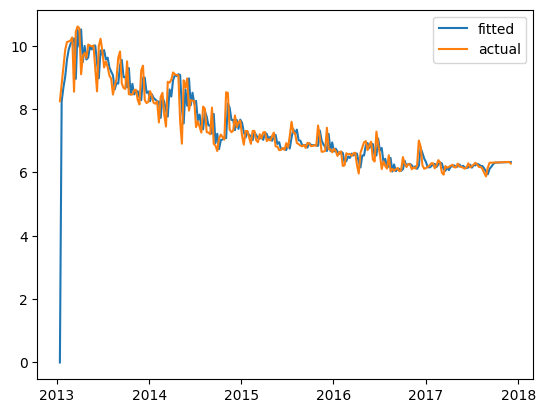

In [32]:
plt.plot(best_arima_model.fittedvalues,label = 'fitted')
plt.plot(df_sun,label = 'actual')
plt.legend()
plt.show()

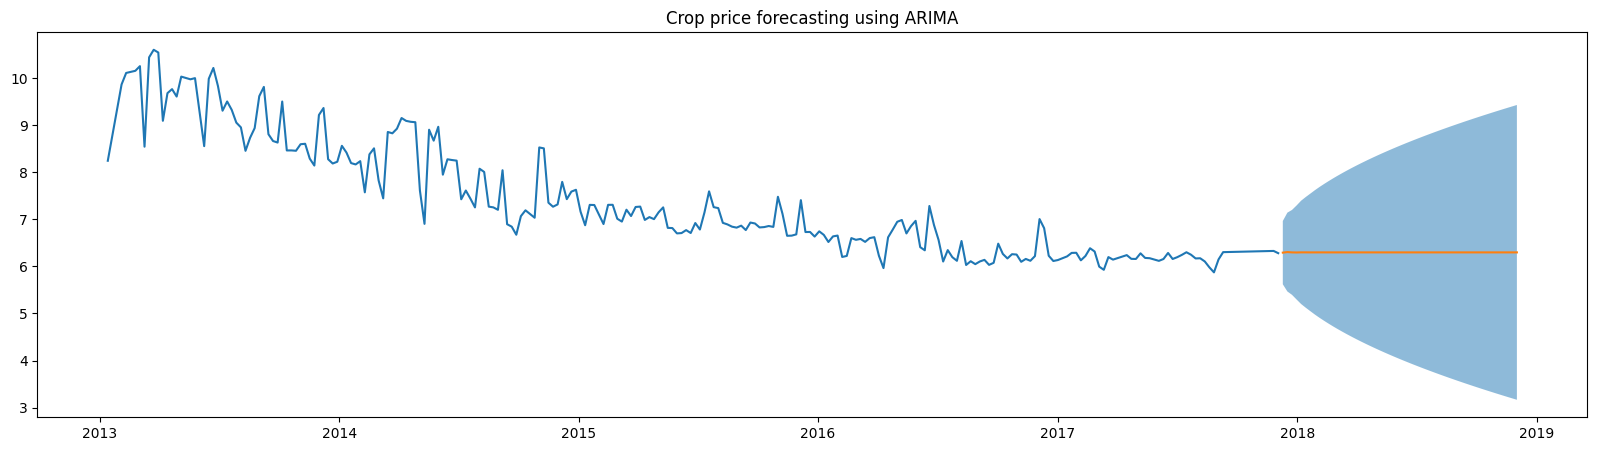

In [33]:
future_fcst = best_arima_model.get_forecast(steps=52)
confidence_int = future_fcst.conf_int(alpha = 0.1)
fcst = future_fcst.predicted_mean

plt.figure(figsize = (20, 5))
plt.title('Crop price forecasting using ARIMA')
plt.plot(df_sun)
plt.plot(fcst, label = 'future forcast')
plt.fill_between(confidence_int.index,confidence_int['lower value'],confidence_int['upper value'],alpha = 0.5)
plt.show()

##SARIMA

In [34]:
# Generate a grid of hyperparameters to search
p_values = [0, 1, 2]  # Autoregressive order
d_values = [0, 1]     # Integrated order
q_values = [0, 1, 2]  # Moving average order
P_values = [0, 1, 2]  # Seasonal autoregressive order
D_values = [0, 1]     # Seasonal integrated order
Q_values = [0, 1, 2]  # Seasonal moving average order
s_values = [4]       # Seasonal periodicity

# Create all possible combinations of hyperparameters
hyperparameter_grid = list(product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

best_mse = float('inf')
best_params = None

# Perform grid search
for params in hyperparameter_grid:
    p, d, q, P, D, Q, s = params
    try:
        model = sm.tsa.SARIMAX(df_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
        fitted_model = model.fit(disp=False)
        predictions = fitted_model.forecast(len(df_test))
        mse = mean_squared_error(df_test, predictions)

        if mse < best_mse:
            best_mse = mse
            best_params = params
    except:
        continue

# Fit the best ARIMA model on the entire dataset
p, d, q, P, D, Q, s = best_params
best_sarima_model = sm.tsa.SARIMAX(df_sun, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()

In [35]:
print("Best hyperparameters:", best_params)
print("Best MSE:", best_mse)

Best hyperparameters: (1, 1, 0, 2, 0, 2, 4)
Best MSE: 0.014292421727533993


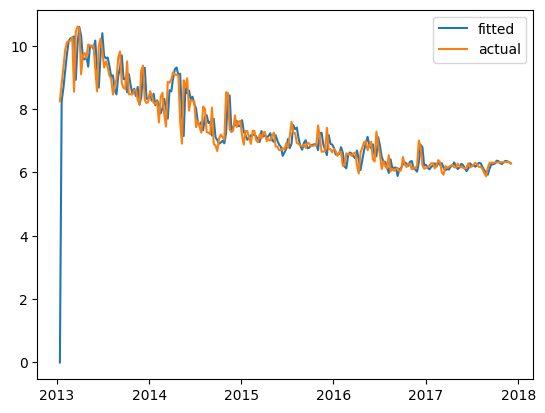

In [36]:
plt.plot(best_sarima_model.fittedvalues, label = 'fitted')
plt.plot(df_sun, label = 'actual')
plt.legend()
plt.show()

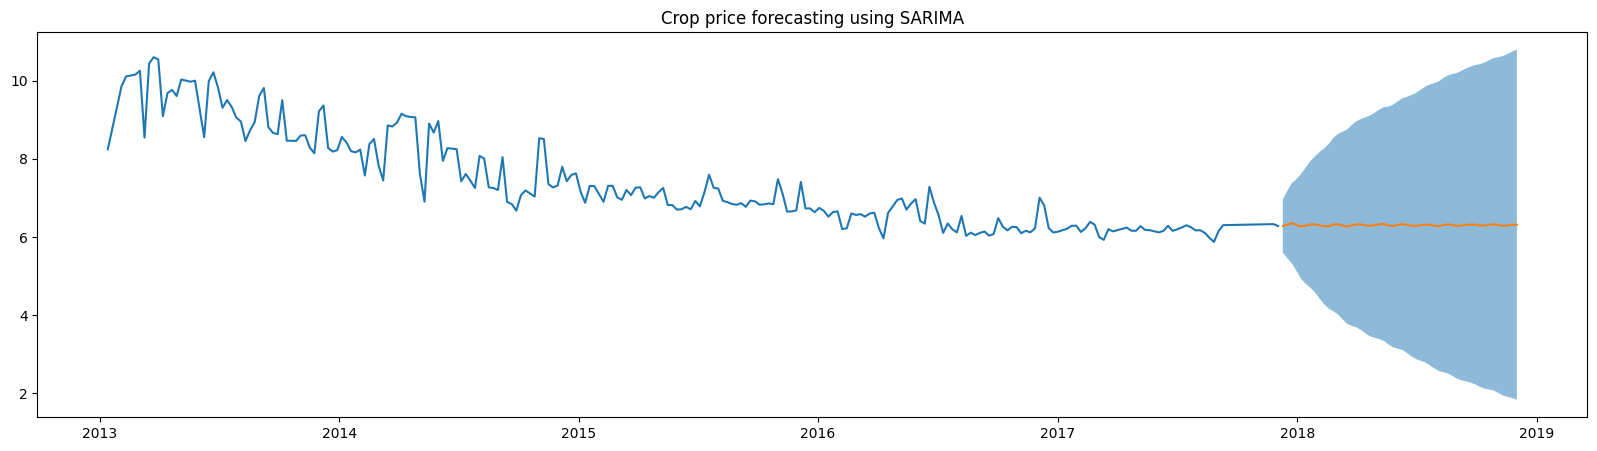

In [37]:
future_fcst = best_sarima_model.get_forecast(steps=52)
confidence_int = future_fcst.conf_int(alpha = 0.1)
fcst = future_fcst.predicted_mean

plt.figure(figsize = (20, 5))
plt.title('Crop price forecasting using SARIMA')
plt.plot(df_sun)
plt.plot(fcst, label = 'forcast')
plt.fill_between(confidence_int.index,confidence_int['lower value'],confidence_int['upper value'],alpha = 0.5)
plt.show()